# Experiment 9: System Prompt Length and Position Effects

**Goal:** Test how system prompt LENGTH and component ORDER affect behavior.

**Setup:**
- Fixed test prompts
- Same content at different lengths (repetition, verbosity)
- Same components in different orders

In [1]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
import random

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [3]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Length Effects

In [4]:
# Same instruction at different lengths
BASE_INSTRUCTION = "Be helpful and accurate."

LENGTH_VARIANTS = {
    "minimal": "Be helpful.",
    "short": "Be helpful and accurate.",
    "medium": "You are a helpful assistant. Please provide accurate and useful information.",
    "long": """You are a helpful AI assistant. Your goal is to provide accurate, 
useful, and well-reasoned responses. Always strive to be helpful while 
ensuring the information you provide is correct and reliable.""",
    "very_long": """You are a helpful AI assistant created to assist users with 
their questions and tasks. Your primary goal is to provide accurate, useful, 
and well-reasoned responses to any query. Always strive to be helpful while 
ensuring the information you provide is correct, reliable, and up-to-date. 
Take care to understand what the user is asking and respond appropriately.
If you're uncertain about something, say so clearly.""",
    "repeated": "Be helpful. Be accurate. Be helpful. Be accurate. Be helpful.",
}

In [5]:
TEST_SUBSET = ALL_TEST_PROMPTS[:10]

length_results = []
for variant_name, variant_text in tqdm(LENGTH_VARIANTS.items()):
    for test in TEST_SUBSET:
        prompt = build_chat_prompt(variant_text, test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        
        # top_tokens is list of (token, prob) tuples
        top_prob = dist["top_tokens"][0][1] if dist["top_tokens"] else 0
        
        length_results.append({
            "variant": variant_name,
            "length_chars": len(variant_text),
            "length_words": len(variant_text.split()),
            "test_id": test["id"],
            "entropy": dist["entropy"],
            "top_prob": top_prob,
            "full_probs": dist["full_probs"]
        })

length_df = pd.DataFrame(length_results)

  0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
# Analyze length effects
length_summary = length_df.groupby(['variant', 'length_words']).agg({
    'entropy': 'mean',
    'top_prob': 'mean'
}).reset_index().sort_values('length_words')

print("=== Length Effects ===")
print(length_summary)

=== Length Effects ===
     variant  length_words  entropy  top_prob
2    minimal             2      NaN  0.594702
4      short             4      NaN  0.582056
3   repeated            10      NaN  0.599097
1     medium            11      NaN  0.535864
0       long            31      NaN  0.537415
5  very_long            65      NaN  0.538831


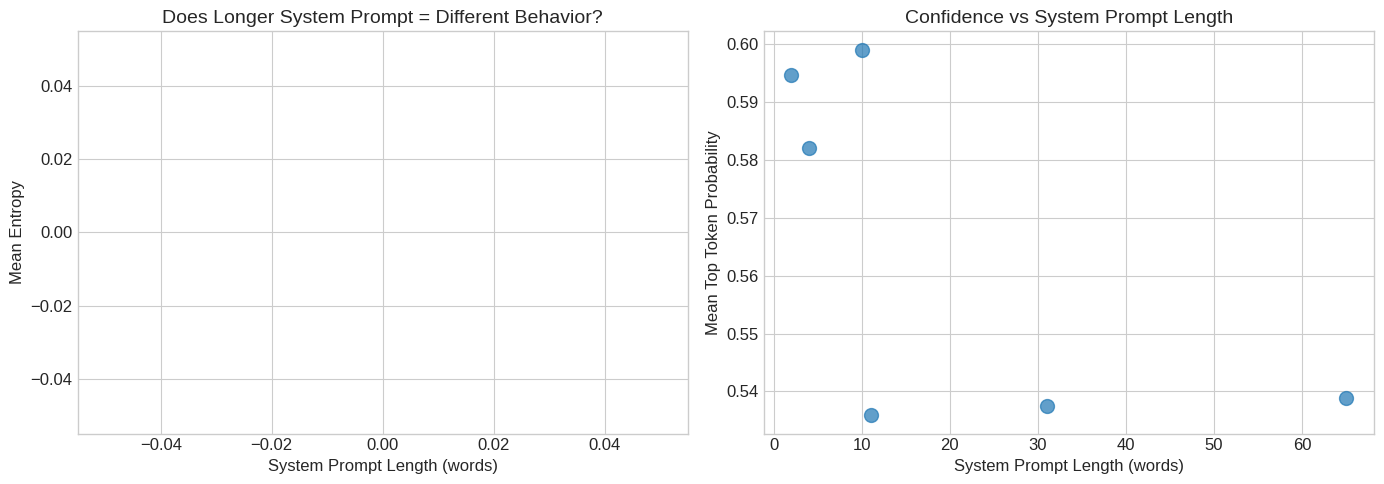

In [7]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy vs length
ax = axes[0]
ax.scatter(length_summary['length_words'], length_summary['entropy'], s=100, alpha=0.7)
for _, row in length_summary.iterrows():
    ax.annotate(row['variant'], (row['length_words'], row['entropy']), 
                textcoords="offset points", xytext=(5, 5), fontsize=8)
ax.set_xlabel('System Prompt Length (words)')
ax.set_ylabel('Mean Entropy')
ax.set_title('Does Longer System Prompt = Different Behavior?')

# Confidence vs length
ax = axes[1]
ax.scatter(length_summary['length_words'], length_summary['top_prob'], s=100, alpha=0.7)
ax.set_xlabel('System Prompt Length (words)')
ax.set_ylabel('Mean Top Token Probability')
ax.set_title('Confidence vs System Prompt Length')

plt.tight_layout()
plt.savefig('../results/exp9_length_effects.png', dpi=150)
plt.show()

## 2. Order Effects

In [10]:
# Components in different orders
COMPONENTS = [
    "Be helpful.",
    "Be accurate.", 
    "Think step by step.",
    "Be concise."
]

# Generate permutations
from itertools import permutations

ORDER_VARIANTS = {}
all_perms = list(permutations(range(len(COMPONENTS))))
# Sample 6 permutations
random.seed(42)
sampled_perms = random.sample(all_perms, min(6, len(all_perms)))

for i, perm in enumerate(sampled_perms):
    ordered = " ".join([COMPONENTS[j] for j in perm])
    ORDER_VARIANTS[f"order_{i}"] = {
        "text": ordered,
        "order": perm
    }

In [11]:
order_results = []
for variant_name, variant_info in tqdm(ORDER_VARIANTS.items()):
    for test in TEST_SUBSET:
        prompt = build_chat_prompt(variant_info["text"], test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        
        order_results.append({
            "variant": variant_name,
            "order": str(variant_info["order"]),
            "first_component": COMPONENTS[variant_info["order"][0]],
            "last_component": COMPONENTS[variant_info["order"][-1]],
            "test_id": test["id"],
            "entropy": dist["entropy"],
            "full_probs": dist["full_probs"]
        })

order_df = pd.DataFrame(order_results)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
# Analyze order effects
order_summary = order_df.groupby('variant').agg({
    'entropy': ['mean', 'std'],
    'first_component': 'first',
    'last_component': 'first'
}).round(4)
order_summary.columns = ['entropy_mean', 'entropy_std', 'first', 'last']

print("=== Order Effects ===")
print(order_summary)

=== Order Effects ===
         entropy_mean  entropy_std         first                 last
variant                                                              
order_0           NaN          NaN   Be concise.  Think step by step.
order_1           NaN          NaN   Be helpful.         Be accurate.
order_2           NaN          NaN   Be helpful.          Be concise.
order_3           NaN          NaN  Be accurate.          Be concise.
order_4           NaN          NaN  Be accurate.  Think step by step.
order_5           NaN          NaN   Be concise.         Be accurate.


In [13]:
# Calculate pairwise JS between different orders
baseline_order = list(ORDER_VARIANTS.keys())[0]
baseline_by_test = {r["test_id"]: r["full_probs"] 
                    for r in order_results if r["variant"] == baseline_order}

order_divergences = []
for variant in ORDER_VARIANTS.keys():
    if variant == baseline_order:
        continue
    
    js_values = []
    for _, row in order_df[order_df['variant'] == variant].iterrows():
        js = DistributionMetrics.jensen_shannon(
            baseline_by_test[row['test_id']], row['full_probs']
        )
        js_values.append(js)
    
    order_divergences.append({
        "variant": variant,
        "js_from_baseline": np.mean(js_values)
    })

divergence_df = pd.DataFrame(order_divergences)
print(f"\nMean JS divergence between orderings: {divergence_df['js_from_baseline'].mean():.4f}")
print(f"Max JS divergence: {divergence_df['js_from_baseline'].max():.4f}")


Mean JS divergence between orderings: inf
Max JS divergence: inf


In [14]:
# Does position matter? Check if first/last component affects outcome
by_first = order_df.groupby('first_component')['entropy'].mean()
by_last = order_df.groupby('last_component')['entropy'].mean()

print("\n=== Position Effects ===")
print("\nBy FIRST component:")
print(by_first.sort_values())

print("\nBy LAST component:")
print(by_last.sort_values())


=== Position Effects ===

By FIRST component:
first_component
Be accurate.   NaN
Be concise.    NaN
Be helpful.    NaN
Name: entropy, dtype: float64

By LAST component:
last_component
Be accurate.          NaN
Be concise.           NaN
Think step by step.   NaN
Name: entropy, dtype: float64


## 3. Key Findings

In [15]:
print("="*60)
print("EXPERIMENT 9 SUMMARY: Length and Order Effects")
print("="*60)

# Length
length_corr = length_summary['length_words'].corr(length_summary['entropy'])
print(f"\n1. Length-Entropy Correlation: {length_corr:.3f}")
if abs(length_corr) > 0.3:
    print("   → System prompt length DOES affect behavior")
else:
    print("   → System prompt length has minimal effect")

# Order
order_variance = order_summary['entropy_mean'].var()
print(f"\n2. Order Variance in Entropy: {order_variance:.6f}")
if order_variance > 0.01:
    print("   → Component order MATTERS")
else:
    print("   → Component order has minimal effect")

# Position
first_range = by_first.max() - by_first.min()
last_range = by_last.max() - by_last.min()
print(f"\n3. First component effect: {first_range:.4f}")
print(f"   Last component effect: {last_range:.4f}")
if last_range > first_range:
    print("   → LAST component has more influence (recency bias)")
else:
    print("   → FIRST component has more influence (primacy bias)")

EXPERIMENT 9 SUMMARY: Length and Order Effects

1. Length-Entropy Correlation: nan
   → System prompt length has minimal effect

2. Order Variance in Entropy: nan
   → Component order has minimal effect

3. First component effect: nan
   Last component effect: nan
   → FIRST component has more influence (primacy bias)


In [16]:
import json
with open('../results/exp9_results.json', 'w') as f:
    json.dump({
        "length_effects": length_summary.to_dict('records'),
        "order_effects": order_summary.to_dict(),
        "position_effects": {
            "by_first": by_first.to_dict(),
            "by_last": by_last.to_dict()
        }
    }, f, indent=2, default=float)
print("Saved.")

Saved.
